In [1]:
from pyspark import SparkContext
import math
import pandas as pd

## Configuração inicial

In [2]:
sc = SparkContext(appName="Teste")

In [3]:
rdd = sc.sequenceFile("pages/part-00000")

In [4]:
#total de documentos na base
total_docs = rdd.count()

#### Funções de tratamento

In [5]:
#Quantas ocorrencias da palavra em todos documentos
def conta_palavras(item):
    texto = item[1]
    palavras = texto.strip().split()
    return [(palavra.lower(),1) for palavra in palavras]

In [6]:
#Conta quantos docs cada palavra aparece
def conta_docs(item):
    texto = item[1]
    palavras = texto.strip().split()
    return [(palavra.lower(),1) for palavra in set(palavras)]
rdd_docs_word = rdd.flatMap(conta_docs).reduceByKey(lambda x,y: x + y).cache()

In [7]:
#Filtra palavras que aparecem em certa quantidade de docs
doc_freq_min = 10
doc_freq_max = 0.7 * total_docs
def filtra(item):
    contagem = item[1]
    return (contagem < doc_freq_max) and (contagem > doc_freq_min)

#RDD com quantos docs cada palavra aparece considerando intervalo limite de 5 a 0.7*total_documentos
rdd_docs_filtrado = rdd_docs_word.filter(filtra)

#### Análise do vocabulário comum

In [8]:
#Calcula idf de cada palavra filtrada
def computa_idf(item):
    palavra, contagem = item
    idf = math.log10(total_docs / contagem)
    return (palavra, idf)
rdd_idf = rdd_docs_filtrado.map(computa_idf)
rdd_idf.take(10)

[('pons', 3.4117759853793284),
 ('r$', 0.5932673172690647),
 ('//}', 3.3274550996792924),
 ('à', 0.32189609502544525),
 ('e-mail', 0.43047524320596725),
 ('bom', 0.8289013117853762),
 ('joaquim', 1.6987657237630354),
 ('cantores', 2.5086859983873846),
 ('região', 0.881576287176246),
 ('*', 0.864528870032381)]

#### Análise do vocabulário específico

In [9]:
#Filtrar RDDs para selecionar conjuntos com cada palavra definida.
rdd_oreo = rdd.filter(lambda x: "oreo" in x[1]) 
rdd_negresco = rdd.filter(lambda x: "negresco" in x[1]) 

In [10]:
#Cálculo da frequência para os RDDs dos dois conjuntos.
rdd_freq_oreo = rdd_oreo.flatMap(conta_palavras).reduceByKey(lambda x,y: x + y).map(lambda x: (x[0], math.log10(1 + x[1]))).cache()
rdd_freq_negresco = rdd_negresco.flatMap(conta_palavras).reduceByKey(lambda x,y: x + y).map(lambda x: (x[0], math.log10(1 + x[1]))).cache()

In [11]:
#Intersecção dos dois conjuntos de frequência.
rdd_inter = rdd_freq_oreo.intersection(rdd_freq_negresco)

##### Tabela com 100 palavras mais relevantes onde os dois itens aparecem conjuntamente

In [31]:
#Calcula 100 palavras mais relevantes em conjunto às palavras escolhidas
rdd_all = rdd_inter.join(rdd_idf).map(lambda x: (x[0], x[1][0]*x[1][1])).takeOrdered(100, key=lambda x: -x[1])
df = pd.DataFrame(rdd_all, columns = ["palavra", "relevancia"])
df_csv = df.to_csv("rdd_all.csv", index=False)

##### Tabela com 100 palavras mais relevantes sem a presença de "negresco"

In [32]:
#Calcula 100 palavras mais relevantes com apenas do conjunto Oreo
rdd_oreo = rdd_freq_oreo.subtractByKey(rdd_freq_negresco).join(rdd_idf).map(lambda x: (x[0], x[1][0]*x[1][1])).takeOrdered(100, key=lambda x: -x[1])
df_o = pd.DataFrame(rdd_oreo, columns = ["palavra", "relevancia"])
df_o_csv = df_o.to_csv("rdd_oreo.csv", index=False)

##### Tabela com 100 palavras mais relevantes sem a presença de "oreo"

In [33]:
#Calcula 100 palavras mais relevantes com apenas do conjunto Negresco
rdd_negresco = rdd_freq_negresco.subtractByKey(rdd_freq_oreo).join(rdd_idf).map(lambda x: (x[0], x[1][0]*x[1][1])).takeOrdered(100, key=lambda x: -x[1])
df_n = pd.DataFrame(rdd_negresco, columns = ["palavra", "relevancia"])
df_n_csv = df_n.to_csv("rdd_negresco.csv", index=False)

In [2]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df_negresco_big = pd.read_csv("rdd_negresco_big.csv")
df_oreo_big = pd.read_csv("rdd_oreo_big.csv")
df_all_big = pd.read_csv("rdd_all_big.csv")

In [4]:
dict_freq_negresco = {}
for i,row in df_negresco_big.iterrows():
    dict_freq_negresco[row["palavra"]] = row["relevancia"]
print(dict_freq_negresco)

{'ambiente!)': 15.813826038324112, 'fechadinho.': 15.344554539817832, 'buttercream!': 15.297567636100345, 'impalpavel.': 15.23551223911206, 'imbc': 15.217900608117812, 'leite!),': 15.215180723133855, 'melyssa,': 15.191846411466392, 'adaires': 15.188546066706266, 'glaçúcar,': 15.165669874711282, 'http://www.cupcakeando.com.br/101s/confeitaria/confeitaria-101-por-que-sou-contra-margarina/': 15.068833929890218, 'aryadna': 15.022501985874493, 'gledis': 14.696577707708338, 'baunilha!': 14.513078451677751, '(imbc)': 14.473423897006937, 'buterrcrem': 14.367955608163594, 'adaires,': 14.367955608163594, 'festa!bjos': 14.367955608163594, '“pozinho”.': 14.361501640739208, 'buttercrem': 14.36106181840348, 'impalpável”': 14.358287057935518, 'esbranquiçou': 14.355080686080244, 'confeiteiro”.': 14.336012564013252, 'buteercream': 14.31930290132007, '“pozinho”': 14.241859353533265, 'grãozinhos,': 14.20154828745151, 'wyllame': 14.13381113937249, 'alcalinizado': 14.006009907832649, 'repassarei': 13.97883

In [5]:
dict_freq_oreo = {}
for i,row in df_oreo_big.iterrows():
    dict_freq_oreo[row["palavra"]] = row["relevancia"]
print(dict_freq_oreo)

{'(diagram': 26.567591194703105, 'uptv': 25.53405670429316, 'ã¢â‚¬å“ã\x90â': 24.75212606336192, 'balletadultokr': 23.45915906976525, 'unicampo': 23.277188529762782, 'ã¢â€šâ¬o': 23.24512605899529, 'scotland,': 23.088173688776386, 'uptv-': 22.59259813223804, 'sã\x90â': 22.32519169931275, 'netmundial': 22.307591088008284, 'cortesia¹': 22.07101852390904, 'desconto¹': 21.097821105485497, 'conta¹': 20.84630847791864, '12/dez/2019': 20.79485782739345, '10/dez/2019': 20.636218742221907, '14/dez/2019': 20.594076042517127, '26/07/21': 20.593625300168746, 'moscow:': 20.330852058907446, '11/dez/2019': 20.31861841958165, 'furfpreelelen': 20.285974018019235, 'files)': 20.247056055918293, 'coaphamma': 20.22885055622498, 'coendyton': 20.22740474410369, 'n°:1': 20.1886724802678, 'shietaknink': 20.10879595227736, 'ã¢â€šâ¬o,': 20.09332515302781, 'fudepen': 20.091604638941156, 'solution-': 19.99552474591242, 'inwalaclady': 19.983960913460407, 'нашей': 19.981754681794648, '19/07/21': 19.98005991850692, '13

In [6]:
dict_freq_all = {}
for i,row in df_all_big.iterrows():
    dict_freq_all[row["palavra"]] = row["relevancia"]
print(dict_freq_all)

{'torturello': 15.480495041741595, 'bakanovas': 15.424280076968234, 'ğïsä': 15.247671563188765, 'prensadinho': 15.203015665691224, 'culinária-receitas': 15.06522644877245, 'eleneid...': 15.036693834092807, 'experimentou)': 15.03149405326392, '(jaque': 14.730103942459193, 'bemcomer': 14.340070414612498, 'maurorebelo@gmail.com': 14.06483485261111, '£igia': 14.045511137931287, 'mauro/apostilas/encarte.htm': 14.034848127911264, 'http://www.martinsrebelo.com/': 14.034848127911264, 'hokudaisai': 13.947321286871858, 'kope)': 13.946722828260734, 'sampuru': 13.946076826553664, 'quiltweek': 13.937303016793289, 'shokuhin': 13.93605945036284, 'tathiy': 13.934839893476596, '(ligia)': 13.933693935433743, 'fairchildart': 13.93358723783138, 'neiman-marcus': 13.932892335475414, '(izamara': 13.932333756712868, 'roscona': 13.931762126897777, '(marnia)': 13.931079449032396, 'gállup': 13.928911703387385, 'http://www.meucartaodenatal.com.br': 13.928568349620173, '´modelador': 13.928568349620173, '}soja': 13

<Figure size 432x288 with 0 Axes>

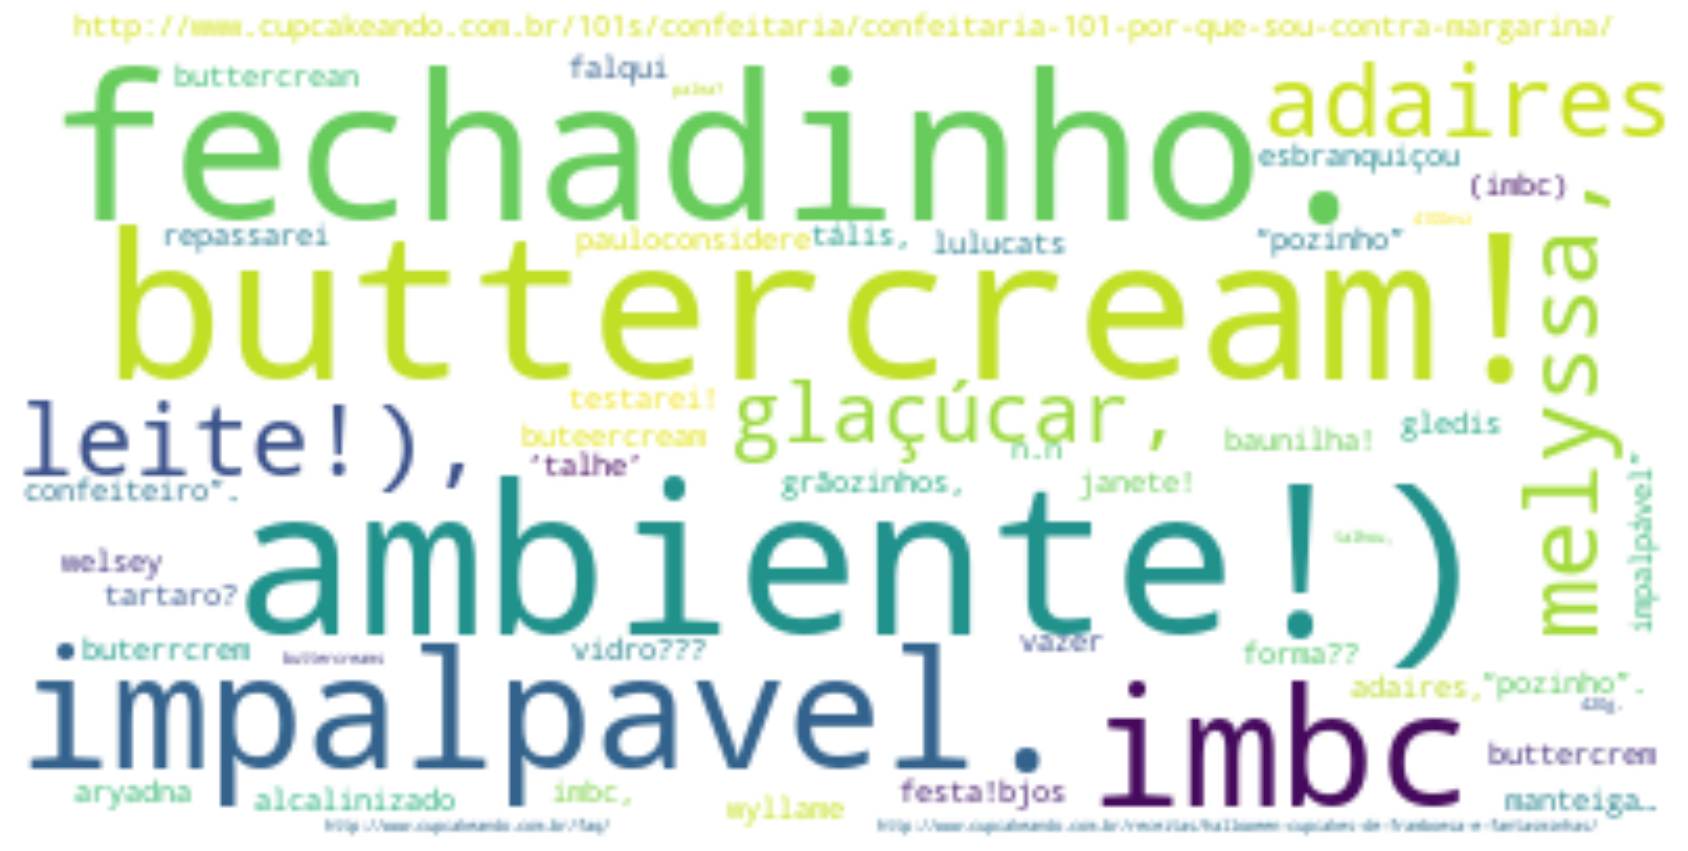

In [8]:
wordcloud_negresco = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(frequencies=dict_freq_negresco)
plt.figure()
plt.figure(figsize=(30,40))
plt.imshow(wordcloud_negresco, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud_negresco.to_file("negrescoWC.png")

<Figure size 432x288 with 0 Axes>

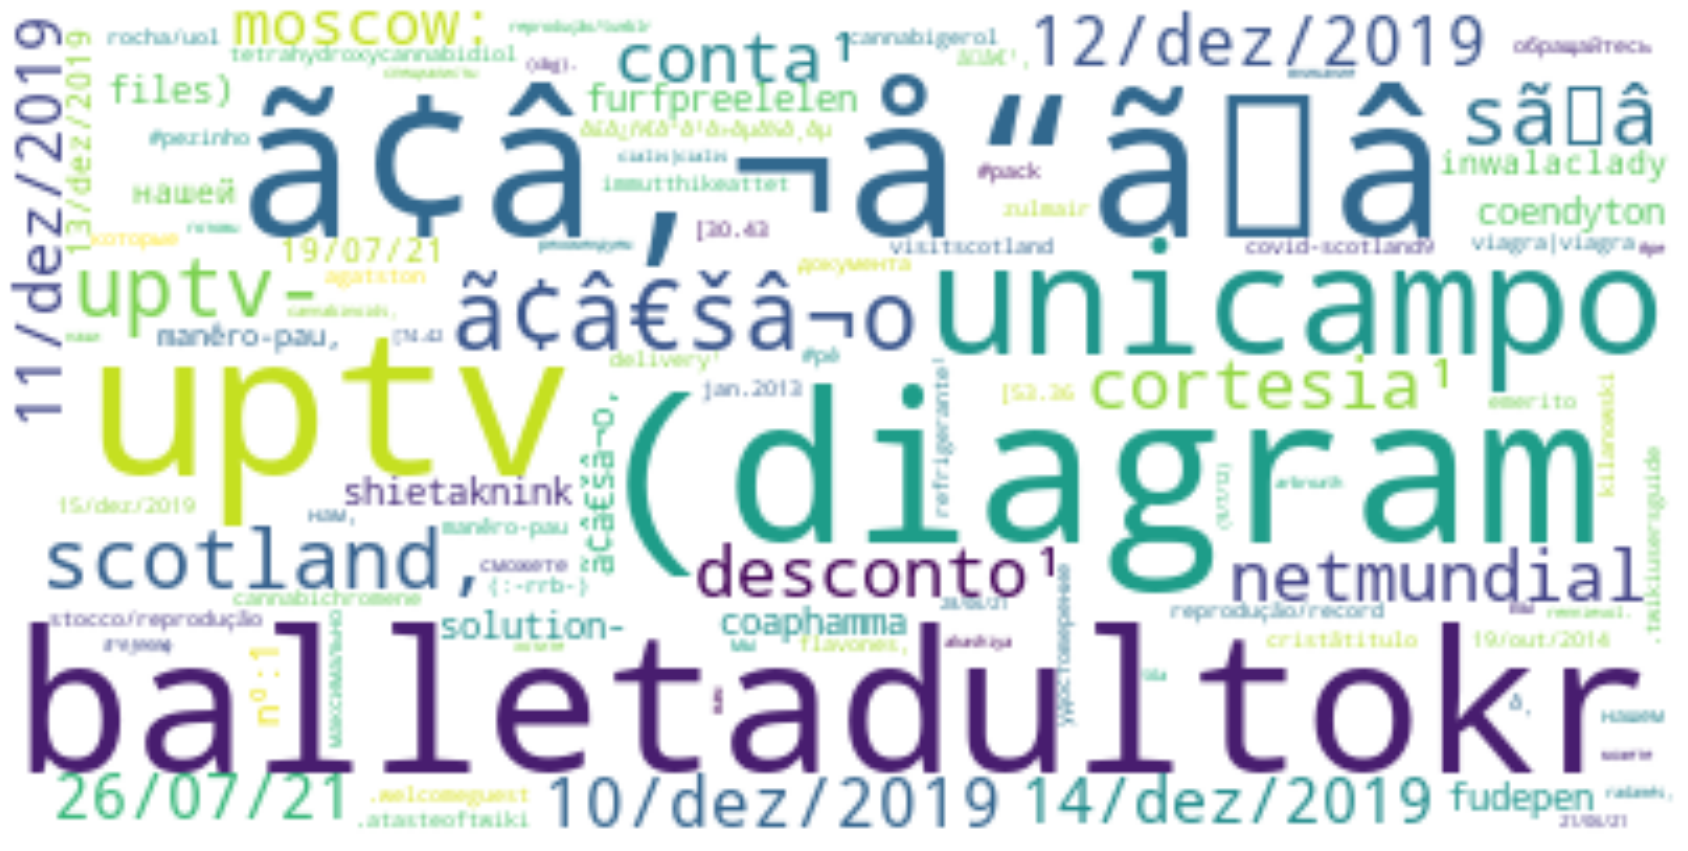

In [9]:
wordcloud_oreo = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(frequencies=dict_freq_oreo)
plt.figure()
plt.figure(figsize=(30,40))
plt.imshow(wordcloud_oreo, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud_oreo.to_file("oreoWC.png")

<Figure size 432x288 with 0 Axes>

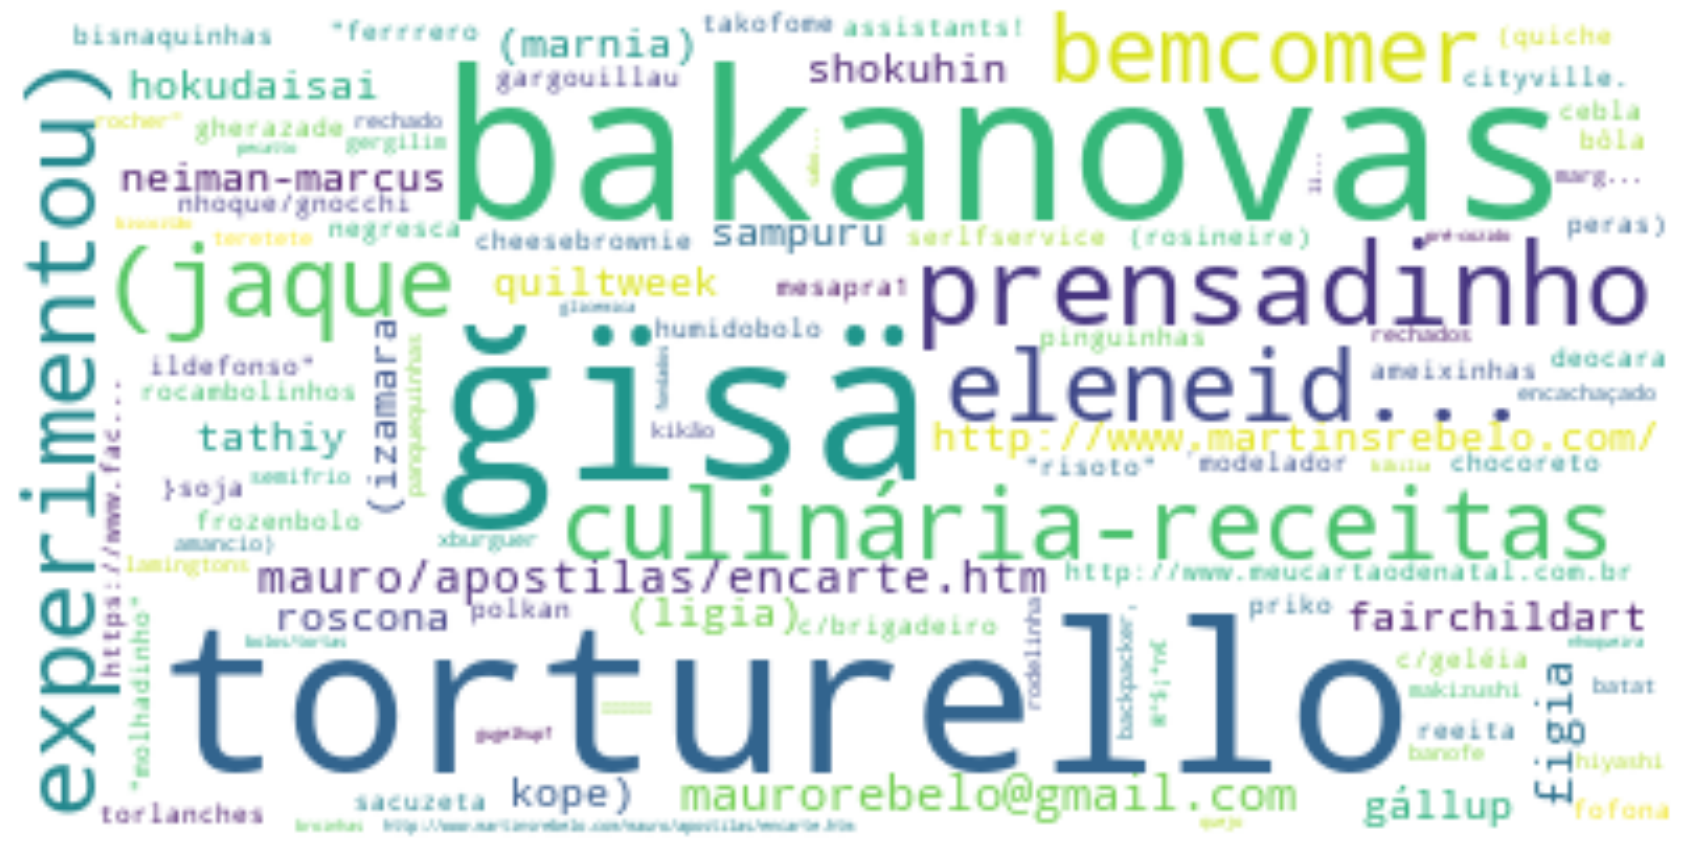

In [11]:
wordcloud_all = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(frequencies=dict_freq_all)
plt.figure()
plt.figure(figsize=(30,40))
plt.imshow(wordcloud_all, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud_all.to_file("allWC.png")